## Model metrics

In [18]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from metrics_utils import *
from numpy.polynomial.polynomial import Polynomial

In [32]:
LOG_PATH = "lightning_logs"
METRICS_PATH = "../Metrics"
model_ids = ['g_lenet_cut_dataset_repeat',
             'lenet_cut_dataset_repeat',
             'resnet18_cut_dataset_repeat',
             'resnet50_cut_dataset_repeat',
             'jiaresnet50_cut_dataset_repeat',
             'g_resnet18_cut_dataset_repeat',
             'g_resnet50_cut_dataset_repeat',
             'g_resnet18_old_cut_dataset_repeat',
             'g_resnet18_cut_dataset_c_repeat']

## Training metrics

In [31]:
repeat_metrics = get_results_runs(model_ids,'val',METRICS_PATH)
repeat_metrics.head(9)

lenet_cut_dataset_repeat: Removed 4 NaNs
Error with g_resnet50_cut_dataset_repeat, run 1
Error with g_resnet50_cut_dataset_repeat, run 2
Error with g_resnet50_cut_dataset_repeat, run 3
Error with g_resnet50_cut_dataset_repeat, run 4
Error with g_resnet18_cut_dataset_c_repeat, run 0
Error with g_resnet18_cut_dataset_c_repeat, run 1
Error with g_resnet18_cut_dataset_c_repeat, run 2
Error with g_resnet18_cut_dataset_c_repeat, run 3
Error with g_resnet18_cut_dataset_c_repeat, run 4


/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

Model,Loss,Accuracy,ECE,C Viol
g_lenet_cut_dataset_repeat,0.7821 ± 0.0351,77.54% ± 2.58%,0.1587 ± 0.0089,0.4174 ± 0.2577
lenet_cut_dataset_repeat,0.8562 ± 0.0341,70.61% ± 3.42%,0.1421 ± 0.0146,-0.6823 ± 0.0000
resnet18_cut_dataset_repeat,0.5290 ± 0.0003,98.16% ± 0.12%,0.2273 ± 0.0023,0.4963 ± 0.1710
resnet50_cut_dataset_repeat,0.5309 ± 0.0002,97.40% ± 0.13%,0.2195 ± 0.0031,0.7647 ± 0.3068
jiaresnet50_cut_dataset_repeat,0.5310 ± 0.0034,97.65% ± 0.82%,0.2232 ± 0.0066,0.2887 ± 0.0618
g_resnet18_cut_dataset_repeat,0.5324 ± 0.0004,98.04% ± 0.32%,0.2285 ± 0.0041,-0.3925 ± 0.1478
g_resnet50_cut_dataset_repeat,0.5331 ± 0.0000,97.51% ± 0.00%,0.2212 ± 0.0000,0.0545 ± 0.0000
g_resnet18_old_cut_dataset_repeat,0.5346 ± 0.0024,97.79% ± 0.25%,0.2235 ± 0.0041,0.5458 ± 0.1820
g_resnet18_cut_dataset_c_repeat,nan ± nan,nan% ± nan%,nan ± nan,nan ± nan


## Testing metrics

In [33]:
repeat_metrics = get_results_runs(model_ids,'test',METRICS_PATH)
repeat_metrics.head(9)

g_lenet_cut_dataset_repeat: Removed 4 NaNs
lenet_cut_dataset_repeat: Removed 5 NaNs
resnet18_cut_dataset_repeat: Removed 1 NaNs
resnet50_cut_dataset_repeat: Removed 1 NaNs
g_resnet18_cut_dataset_repeat: Removed 1 NaNs
Error with g_resnet50_cut_dataset_repeat, run 0
Error with g_resnet50_cut_dataset_repeat, run 1
Error with g_resnet50_cut_dataset_repeat, run 2
Error with g_resnet50_cut_dataset_repeat, run 3
Error with g_resnet50_cut_dataset_repeat, run 4
Error with g_resnet18_cut_dataset_c_repeat, run 0
Error with g_resnet18_cut_dataset_c_repeat, run 1
Error with g_resnet18_cut_dataset_c_repeat, run 2
Error with g_resnet18_cut_dataset_c_repeat, run 3
Error with g_resnet18_cut_dataset_c_repeat, run 4


/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

Model,Loss,Accuracy,ECE,C Viol
g_lenet_cut_dataset_repeat,0.5098 ± 0.0087,89.53% ± 0.28%,0.1545 ± 0.0085,0.1405 ± 0.0000
lenet_cut_dataset_repeat,0.5192 ± 0.0095,89.60% ± 0.60%,0.1797 ± 0.0121,nan ± nan
resnet18_cut_dataset_repeat,0.4514 ± 0.0075,92.18% ± 0.29%,0.1109 ± 0.0040,0.9351 ± 0.3880
resnet50_cut_dataset_repeat,0.4579 ± 0.0077,92.32% ± 0.37%,0.1201 ± 0.0060,1.3171 ± 0.4113
jiaresnet50_cut_dataset_repeat,0.4075 ± 0.0023,94.27% ± 0.06%,0.1171 ± 0.0063,0.0117 ± 0.0550
g_resnet18_cut_dataset_repeat,0.4119 ± 0.0298,93.33% ± 1.10%,0.1053 ± 0.0082,0.7135 ± 0.3542
g_resnet50_cut_dataset_repeat,nan ± nan,nan% ± nan%,nan ± nan,nan ± nan
g_resnet18_old_cut_dataset_repeat,0.4723 ± 0.0548,91.09% ± 1.64%,0.1063 ± 0.0089,0.3742 ± 0.5673
g_resnet18_cut_dataset_c_repeat,nan ± nan,nan% ± nan%,nan ± nan,nan ± nan


In [5]:
#          blue      orange     reddish purple  sky blue   bluish green  amber        vermillion  
colours = ["#0072B2","#E69F00","#CC79A7",       "#56B4E9",  "#009E73",   "#F5C710",  "#D55E00"  ]
colours = ["#0072B2","#E69F00","#CC79A7",       "#56B4E9",  "#009E73",  "#D55E00","#D55E00"  ]

def plot_combined_metrics(model_ids,metric,metric_label):
    fig = plt.figure(figsize=(9,4))
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel(metric_label)

    for i,model in enumerate(model_ids):
        metrics = get_metrics_from_csv(model,METRICS_PATH,version=2,mode='train')
        m = metrics[metric]
        epoch = metrics.index
        label = model.removesuffix('_cut_dataset_repeat')
        ax1.plot(epoch,m,linestyle='-',c=colours[i],label=label,linewidth=1.7)
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.grid()
    plt.show()

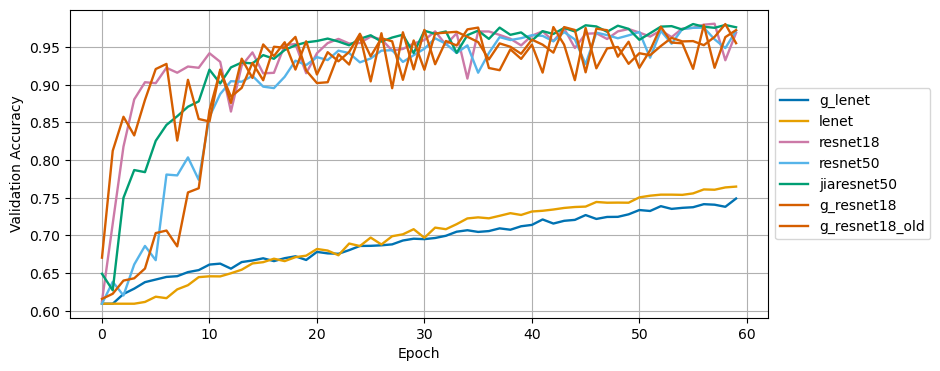

In [6]:
plot_combined_metrics(model_ids,'val_acc','Validation Accuracy')

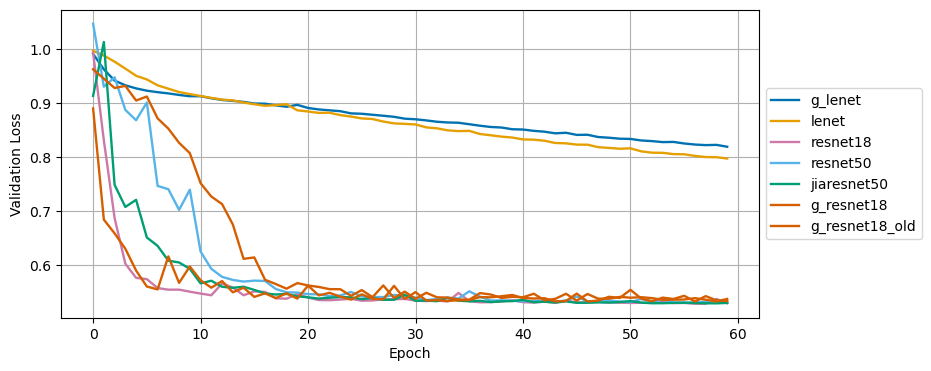

In [7]:
plot_combined_metrics(model_ids,'val_loss','Validation Loss')

## Prediction Metrics

In [8]:
def summarise_predictions(model_id,dataset_name,version=0):
    predictions = pd.read_csv(f"{METRICS_PATH}/{model_id}/version_{version}/{dataset_name}_predictions.csv", names=['CW','ACW','Other'],on_bad_lines = 'skip').astype('float')
    num = predictions.shape[0]
    num_cw = np.count_nonzero(predictions['CW']>0.5)
    num_acw = np.count_nonzero(predictions['ACW']>0.5)
    num_other = num - num_acw - num_acw
    print(f"Total: {num}. ACW: {num_acw} ({num_acw/num:.1%}). CW: {num_cw} ({num_cw/num:.1%}). Other: {num_other} ({num_other/num:.1%})")
    print(f"Chirality Violation: {chirality_violation(predictions):3.2f} sigma")

#summarise_predictions("resnet18_cut_dataset","full_desi_dataset")

In [9]:
model_ids = ['resnet18_cut_dataset_repeat',
             'resnet50_cut_dataset_repeat',
            'jiaresnet50_cut_dataset_repeat',
            'g_resnet18_cut_dataset_repeat',
             'g_resnet18_old_cut_dataset_repeat']

repeat_metrics = get_predict_results_runs(model_ids,5,METRICS_PATH)
repeat_metrics.head(6)

Model,ACW,CW,Other,C Viol
resnet18_cut_dataset_repeat,10048 (1.0%) ± 1521,8671 (0.9%) ± 1538,979904 (98.0%) ± 3043,10.18 ± 3.78
resnet50_cut_dataset_repeat,9913 (1.0%) ± 913,8009 (0.8%) ± 828,980174 (98.0%) ± 1826,14.25 ± 6.61
jiaresnet50_cut_dataset_repeat,12373 (1.2%) ± 808,12387 (1.2%) ± 802,975254 (97.5%) ± 1616,-0.09 ± 0.64
g_resnet18_cut_dataset_repeat,11846 (1.2%) ± 5314,13405 (1.3%) ± 2990,976309 (97.6%) ± 10628,-13.11 ± 44.02
g_resnet18_old_cut_dataset_repeat,12763 (1.3%) ± 5136,12365 (1.2%) ± 6016,974473 (97.4%) ± 10271,3.70 ± 27.71


In [10]:
def get_predict_results_runs_cviol(model_ids,c_viols_list,max_runs=5,dataset_name="cut_dataset"):
    repeat_metrics = pd.DataFrame(columns=["C Viol", "C Viol Err","N Spirals","N Spirals Err"],index=model_ids)
    repeat_metrics.columns.name="Model"
    for model in model_ids:
        c_viols = []
        c_viols_err = []
        num_spirals = []
        num_spirals_err = []
        for c_viol in c_viols_list:
            predicted_c_viols = []
            predicted_num_spirals = []
            for run in range(max_runs):
                #try:
                predictions = pd.read_csv(f"{METRICS_PATH}/{model}/version_{run}/{dataset_name}_CVIOL_{c_viol}_predictions.csv",header=None,names=['CW','ACW','Other'], on_bad_lines = 'skip').astype('float')
                predicted_c_viols.append(chirality_violation(predictions))
                predicted_num_spirals.append(count_spirals(predictions))
                #except:
                #    print(f"Error with {model}, run {run}, cviol {c_viol}")
            c_viols.append(np.average(predicted_c_viols))
            c_viols_err.append(np.std(predicted_c_viols))
            num_spirals.append(np.average(predicted_num_spirals))
            num_spirals_err.append(np.std(predicted_num_spirals))
        
        repeat_metrics.loc[model] = {"C Viol": c_viols,
                                        "C Viol Err": c_viols_err,
                                        "N Spirals": num_spirals,
                                        "N Spirals Err": num_spirals_err}
    return repeat_metrics


def plot_cviols(repeat_metrics,model_ids,c_viols_list):
    fig = plt.figure(figsize=(9,7))

    for i,model in enumerate(model_ids):
        ax = fig.add_subplot(3,2,i+1)
        ax.set_ylabel('Model Predicted C Viol')
        ax.set_xlabel('Test Dataset Actual C Viol')
        c_viols = repeat_metrics["C Viol"].iloc[i]
        c_viols_err = repeat_metrics["C Viol Err"].iloc[i]
        label = model.removesuffix('_cut_dataset_repeat')
        ax.errorbar(c_viols_list,c_viols,yerr=c_viols_err,fmt="x",linewidth=1.7,capsize=5) #label=label
        ax.plot(c_viols_list,c_viols_list,linewidth=1.7,label="Ideal")
        fit = Polynomial.fit(c_viols_list,c_viols,deg=1,w=c_viols_err)
        ax.plot(*fit.linspace(10),label=f"y = {fit.convert().coef[1]:3.2f} x + {fit.convert().coef[0]:3.2f}")
        ax.grid()
        ax.set_title(label)
        ax.set_xticks(c_viols_list)
        ax.legend()
    plt.tight_layout()
    plt.show()

def plot_spiral_nums(repeat_metrics,model_ids,c_viols_list):
    fig = plt.figure(figsize=(9,7))

    for i,model in enumerate(model_ids):
        ax = fig.add_subplot(3,2,i+1)
        ax.set_ylabel('% Spirals Predicted')
        ax.set_xlabel('Test Dataset Actual C Viol')
        num_actual = 2333
        num_spirals = np.array(repeat_metrics["N Spirals"].iloc[i])/num_actual
        num_spirals_err = np.array(repeat_metrics["N Spirals Err"].iloc[i])/num_actual
        label = model.removesuffix('_cut_dataset_repeat')
        ax.errorbar(c_viols_list,num_spirals,yerr=num_spirals_err,fmt="x",linewidth=1.7,capsize=5) #label=label
        ax.grid()
        ax.set_title(label)
        ax.set_xticks(c_viols_list)
        ax.set_yticks(np.arange(0.2,0.8,0.1))
        #ax.legend()
    plt.tight_layout()
    plt.show()

In [35]:
model_ids = ['resnet18_cut_dataset_repeat',
             'resnet50_cut_dataset_repeat',
            'jiaresnet50_cut_dataset_repeat',
             'g_resnet18_cut_dataset_repeat',
            'g_resnet18_old_cut_dataset_repeat']
chirality_list = [-12,-9,-6,-3,0,3,6,9,12]
cviol_table = get_predict_results_runs_cviol(model_ids,chirality_list)
#cviol_table.head(5)

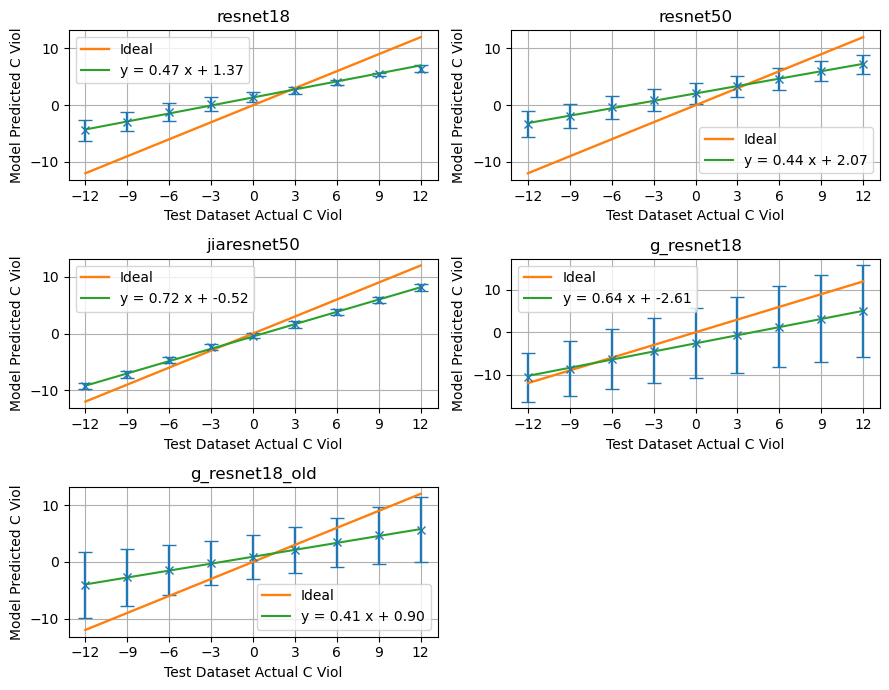

In [12]:
plot_cviols(cviol_table,model_ids,chirality_list)

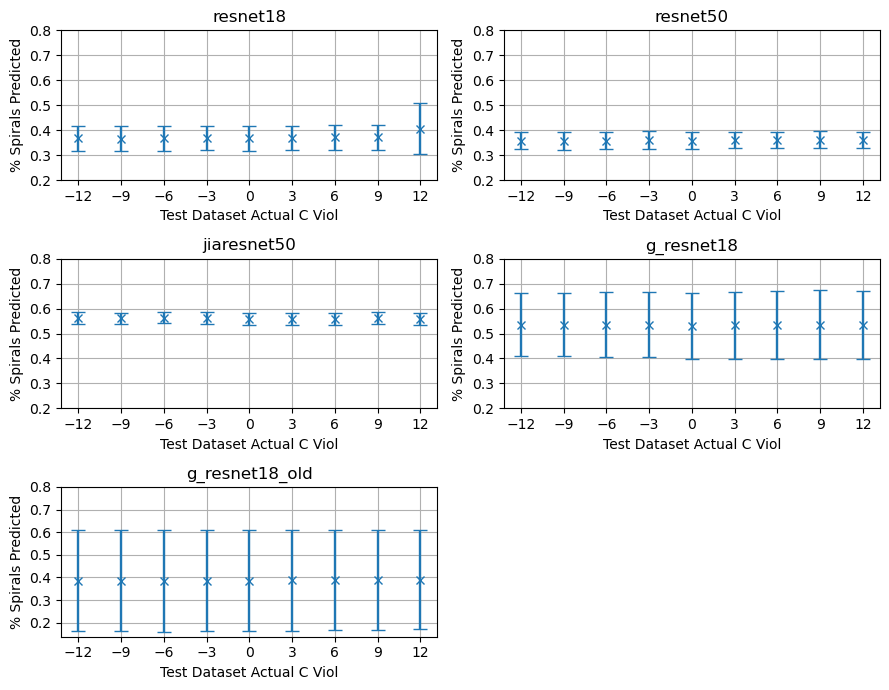

In [13]:
plot_spiral_nums(cviol_table,model_ids,chirality_list)

In [41]:
def plot_vote_fractions(cat,title):
    labels = ["CW","ACW","Other"]
    nice_labels = ["Clockwise Spiral","Anticlockwise Spiral","Other"]
    fig = plt.figure(figsize=(10,3))
    for i, labels in enumerate(labels):
        ax_i = fig.add_subplot(1,3,i+1)
        ax_i.hist(cat[labels],bins=10)
        ax_i.set_title(nice_labels[i])
        ax_i.set_ylim(0,1000)
        ax_i.set_xlim(0,1)
        if i==0:
            ax_i.set_ylabel("Count")
        elif i==1:
            ax_i.set_xlabel("Vote Fractions")
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def compare_probabilities(model_ids,c_viol,max_runs=5,dataset_name="cut_dataset"):
    for model in model_ids:
            run = 2
            predictions = pd.read_csv(f"{METRICS_PATH}/{model}/version_{run}/{dataset_name}_CVIOL_{c_viol}_predictions.csv", names=['CW','ACW','Other'],on_bad_lines = 'skip').astype('float')
            plot_vote_fractions(predictions,model.removesuffix('_cut_dataset_repeat'))

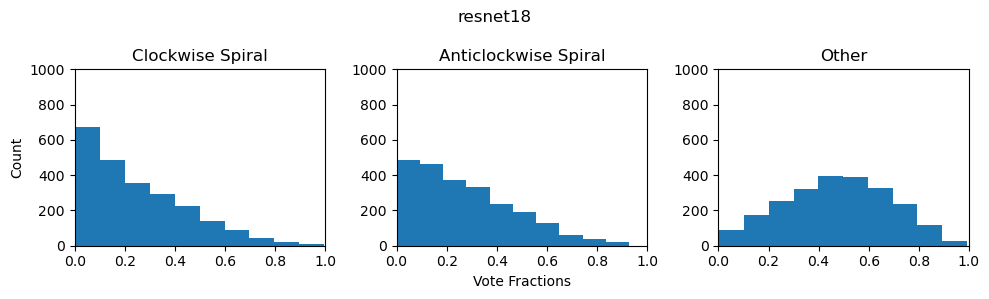

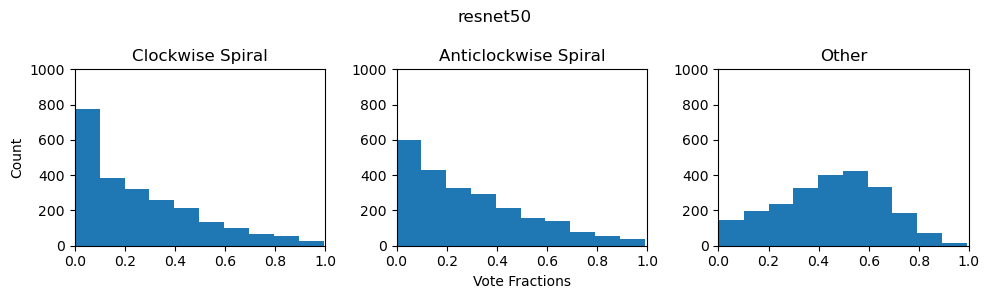

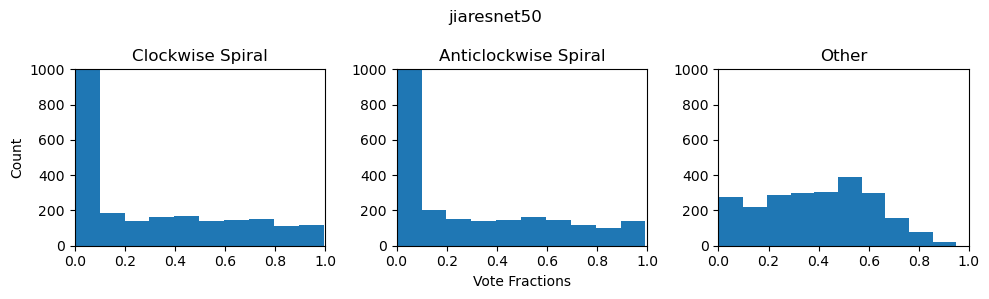

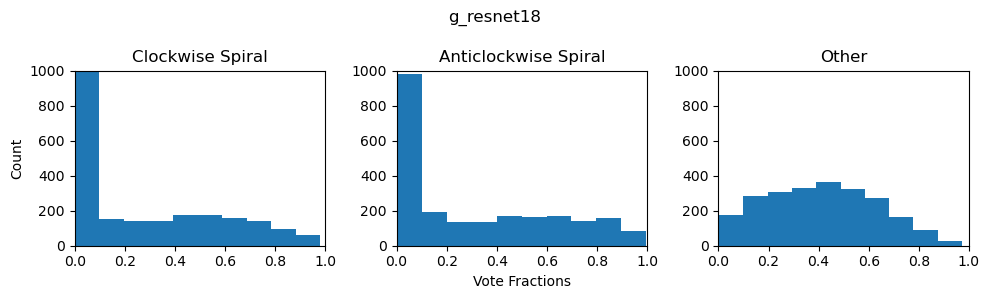

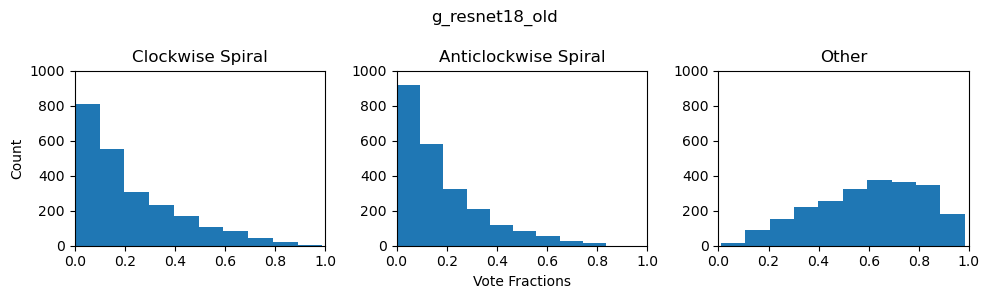

In [42]:
compare_probabilities(model_ids,0)